# ポアソン回帰モデル

**ポアソン回帰モデル**（Poisson regression model）は、目的変数がカウントデータ（非負整数値）である場合のGLMである。事故件数、来店回数、死亡数など、「一定期間内の発生回数」をモデリングするのに用いられる。

## GLMとしての定式化

### 変量成分

目的変数 $Y_i$ は平均 $\mu_i$ のポアソン分布に従う：

$$
Y_i \sim \text{Poisson}(\mu_i), \quad P(Y_i = y) = \frac{\mu_i^y \, e^{-\mu_i}}{y!}, \quad y = 0, 1, 2, \dots
$$

ポアソン分布は指数型分布族に属する。確率関数を

$$
f(y_i \mid \mu_i) = \exp\left( y_i \log \mu_i - \mu_i - \log y_i! \right)
$$

と書けば、自然パラメータが $\eta_i = \log \mu_i$ であることがわかる。

ポアソン分布の重要な性質として、平均と分散が等しい：

$$
E[Y_i] = \text{Var}(Y_i) = \mu_i
$$

### リンク関数

自然パラメータに対応する正準リンクとして、**対数リンク**（log link）を用いる：

$$
g(\mu_i) = \log \mu_i
$$

対数リンクにより、$\mu_i = \exp(\eta_i) > 0$ が自動的に保証される。これはカウントデータの平均が非負であるという制約を自然に満たす。

### 系統的成分

線形予測子は

$$
\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta} = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip}
$$

### 3つをまとめると

$$
\log \mu_i = \mathbf{x}_i^\top \boldsymbol{\beta}
$$

逆リンク関数（指数関数）で $\mu_i$ を表すと

$$
\mu_i = \exp(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

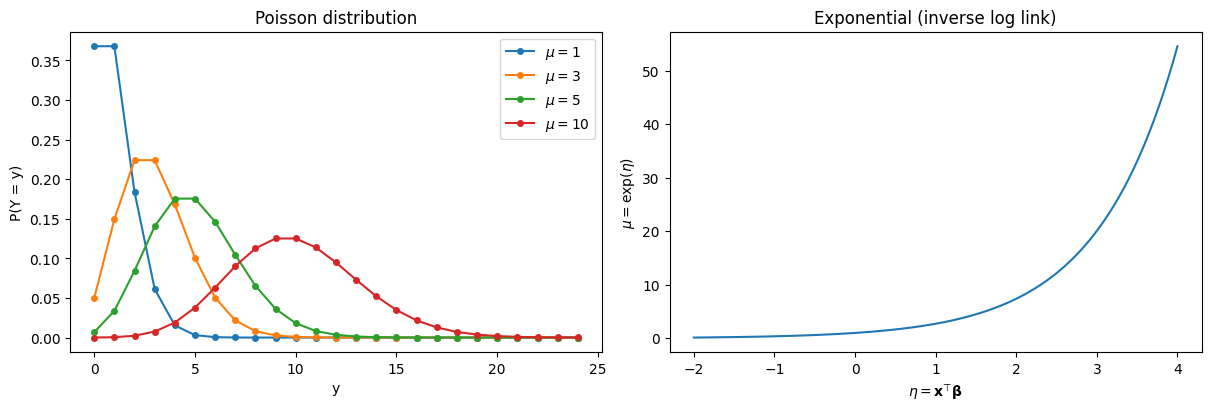

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ポアソン分布と指数リンクの可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# 左: 異なるμのポアソン分布
for mu in [1, 3, 5, 10]:
    k = np.arange(0, 25)
    pmf = stats.poisson.pmf(k, mu)
    axes[0].plot(k, pmf, "o-", markersize=4, label=rf"$\mu = {mu}$")
axes[0].set(xlabel="y", ylabel="P(Y = y)", title="Poisson distribution")
axes[0].legend()

# 右: 指数リンク（逆リンク関数）
eta = np.linspace(-2, 4, 300)
mu = np.exp(eta)
axes[1].plot(eta, mu)
axes[1].set(xlabel=r"$\eta = \mathbf{x}^\top \mathbf{\beta}$",
            ylabel=r"$\mu = \exp(\eta)$",
            title="Exponential (inverse log link)")

plt.show()

## 係数の解釈：発生率比（IRR）

ロジスティック回帰で係数がオッズ比として解釈できたのと同様に、ポアソン回帰の係数は**発生率比**（Incidence Rate Ratio: IRR）として解釈できる。

説明変数 $x_j$ が1単位増加したときの期待カウントの変化率を考えると

$$
\frac{\mu(x_j + 1)}{\mu(x_j)}
= \frac{\exp(\cdots + \beta_j(x_j + 1) + \cdots)}{\exp(\cdots + \beta_j x_j + \cdots)}
= \exp(\beta_j)
$$

すなわち $\exp(\beta_j)$ は、他の変数を一定に保ったとき $x_j$ が1単位増加した場合の期待カウントの**乗法的な変化倍率**である。

- $\beta_j > 0 \Leftrightarrow \exp(\beta_j) > 1$：$x_j$ が増えると期待カウントが増加
- $\beta_j = 0 \Leftrightarrow \exp(\beta_j) = 1$：$x_j$ は期待カウントに影響しない
- $\beta_j < 0 \Leftrightarrow \exp(\beta_j) < 1$：$x_j$ が増えると期待カウントが減少

例えば $\beta_j = 0.3$ なら $\exp(0.3) \approx 1.35$ なので、$x_j$ が1単位増えると発生率が約35%増加すると解釈する。

## 最尤推定

### 対数尤度関数

$n$ 個の独立な観測 $(y_i, \mathbf{x}_i)$ に対する対数尤度は

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i \log \mu_i - \mu_i - \log y_i! \right]
$$

$\mu_i = \exp(\mathbf{x}_i^\top \boldsymbol{\beta})$ を代入すると

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i\, \mathbf{x}_i^\top \boldsymbol{\beta} - \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) - \log y_i! \right]
$$

### スコア関数

$$
\frac{\partial \ell}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} (y_i - \mu_i)\, \mathbf{x}_i = \mathbf{X}^\top (\mathbf{y} - \boldsymbol{\mu})
$$

ロジスティック回帰の場合と同じ形 $\mathbf{X}^\top(\mathbf{y} - \hat{\boldsymbol{\mu}})$ となる。これは正準リンクを用いたGLM一般に成り立つ性質である。

### Fisher情報行列

$$
\mathbf{F}(\boldsymbol{\beta}) = -\frac{\partial^2 \ell}{\partial \boldsymbol{\beta}\, \partial \boldsymbol{\beta}^\top} = \mathbf{X}^\top \mathbf{W} \mathbf{X}
$$

ここで $\mathbf{W} = \text{diag}(\mu_1, \dots, \mu_n)$ である。ポアソン分布では分散が平均に等しいため、重み $w_i = \mu_i$ となる。

### IRLS

ロジスティック回帰と同様に、IRLSで解く。更新式は

$$
\boldsymbol{\beta}^{(t+1)} = (\mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{X})^{-1}\, \mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{z}^{(t)}
$$

作業従属変数は

$$
z_i^{(t)} = \eta_i^{(t)} + \frac{y_i - \mu_i^{(t)}}{\mu_i^{(t)}}
$$

リンク関数の微分 $g'(\mu) = 1/\mu$ が反映されている。

### 逸脱度



### IRLSのスクラッチ実装

In [20]:
def poisson_regression_irls(
    X: np.ndarray,
    y: np.ndarray,
    max_iter: int = 25,
    tol: float = 1e-8,
) -> dict:
    """
    IRLSによるポアソン回帰の最尤推定

    Parameters
    ----------
    X : np.ndarray, shape (n, p)
        計画行列（切片列を含む）
    y : np.ndarray, shape (n,)
        目的変数（非負整数）
    max_iter : int
        最大反復回数
    tol : float
        収束判定の閾値

    Returns
    -------
    dict
        beta, se, log_likelihood, n_iter, deviance
    """
    n, p = X.shape
    beta = np.zeros(p)
    # 初期値: 切片を log(yの平均) に設定
    beta[0] = np.log(max(y.mean(), 1e-4))

    for iteration in range(max_iter):
        eta = X @ beta
        mu = np.exp(eta)

        # 重み: ポアソンでは w_i = mu_i
        w = mu.copy()
        w = np.clip(w, 1e-10, None)

        # 作業従属変数
        z = eta + (y - mu) / w

        # 重み付き最小二乗法
        W = np.diag(w)
        XtWX = X.T @ W @ X
        XtWz = X.T @ W @ z

        beta_new = np.linalg.solve(XtWX, XtWz)

        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    # 最終結果
    eta = X @ beta
    mu = np.exp(eta)
    log_lik = np.sum(y * np.log(mu + 1e-15) - mu - np.array([np.math.lgamma(yi + 1) for yi in y]))

    # 逸脱度
    mask = y > 0
    term = np.zeros_like(mu, dtype=float)
    term[mask] = y[mask] * np.log(y[mask] / mu[mask])
    deviance = 2 * np.sum(term - (y - mu))

    # 標準誤差
    XtWX = X.T @ np.diag(mu) @ X
    cov = np.linalg.inv(XtWX)
    se = np.sqrt(np.diag(cov))

    return {
        "beta": beta,
        "se": se,
        "log_likelihood": log_lik,
        "deviance": deviance,
        "n_iter": iteration + 1,
        "cov": cov,
    }

### シミュレーションデータでの検証

スクラッチ実装を `statsmodels` の結果と比較する。

In [21]:
import pandas as pd
import statsmodels.api as sm

# データ生成
rng = np.random.default_rng(42)
n = 500
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
beta_true = np.array([1.0, 0.5, -0.3])  # beta_0, beta_1, beta_2
X = np.column_stack([np.ones(n), x1, x2])
eta = X @ beta_true
mu_true = np.exp(eta)
y = rng.poisson(mu_true)

print(f"サンプルサイズ: {n}")
print(f"真の係数: \u03b2\u2080={beta_true[0]}, \u03b2\u2081={beta_true[1]}, \u03b2\u2082={beta_true[2]}")
print(f"yの平均: {y.mean():.3f}, 分散: {y.var():.3f}")

サンプルサイズ: 500
真の係数: β₀=1.0, β₁=0.5, β₂=-0.3
yの平均: 3.226, 分散: 7.703


In [22]:
# スクラッチ実装
result_irls = poisson_regression_irls(X, y)

# statsmodels
model_sm = sm.GLM(y, X, family=sm.families.Poisson())
result_sm = model_sm.fit()

# 比較
comparison = pd.DataFrame({
    "真の値": beta_true,
    "IRLS (自前)": result_irls["beta"],
    "statsmodels": result_sm.params,
    "SE (自前)": result_irls["se"],
    "SE (statsmodels)": result_sm.bse,
}, index=["β\u2080", "β\u2081", "β\u2082"])

print(f"IRLS 反復回数: {result_irls['n_iter']}")
print(f"対数尤度 (自前): {result_irls['log_likelihood']:.4f}")
print(f"対数尤度 (statsmodels): {result_sm.llf:.4f}")
print(f"逸脱度 (自前): {result_irls['deviance']:.4f}")
print(f"逸脱度 (statsmodels): {result_sm.deviance:.4f}")
print()
comparison

IRLS 反復回数: 5
対数尤度 (自前): -939.9157
対数尤度 (statsmodels): -939.9157
逸脱度 (自前): 557.5685
逸脱度 (statsmodels): 557.5685



/tmp/ipykernel_12239/3894540174.py:57: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_lik = np.sum(y * np.log(mu + 1e-15) - mu - np.array([np.math.lgamma(yi + 1) for yi in y]))


,真の値,IRLS (自前),statsmodels,SE (自前),SE (statsmodels)
β₀,1.0,0.991881,0.991881,0.029044,0.029044
β₁,0.5,0.521496,0.521496,0.025434,0.025434
β₂,-0.3,-0.297395,-0.297395,0.024331,0.024331


## 仮説検定とモデル評価

### Wald検定

ロジスティック回帰と同様に、個々の係数について $H_0: \beta_j = 0$ を検定する：

$$
z_j = \frac{\hat{\beta}_j}{\text{SE}(\hat{\beta}_j)}
$$

### 逸脱度（deviance）

飽和モデル（観測ごとにパラメータを持つモデル）との比較で定義される：

$$
D = 2 \sum_{i=1}^{n} \left[ y_i \log\frac{y_i}{\hat{\mu}_i} - (y_i - \hat{\mu}_i) \right]
$$

ただし $y_i = 0$ のときは $y_i \log(y_i / \hat{\mu}_i) = 0$ とする。

モデルが正しければ $D$ は漸近的に自由度 $n - p$ の $\chi^2$ 分布に従う。$D / (n-p)$ が1より大きければ過分散の兆候である。

In [23]:
print(result_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -939.92
Date:                Sat, 14 Feb 2026   Deviance:                       557.57
Time:                        23:22:33   Pearson chi2:                     500.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6738
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9919      0.029     34.151      0.0

In [24]:
# IRR（発生率比）と95%信頼区間
beta_hat = result_sm.params
se = result_sm.bse
z_crit = stats.norm.ppf(0.975)

irr_df = pd.DataFrame({
    "\u03b2": beta_hat,
    "IRR (exp(\u03b2))": np.exp(beta_hat),
    "IRR 95%CI lower": np.exp(beta_hat - z_crit * se),
    "IRR 95%CI upper": np.exp(beta_hat + z_crit * se),
    "p-value": result_sm.pvalues,
}, index=["intercept", "x\u2081", "x\u2082"])

irr_df

,β,IRR (exp(β)),IRR 95%CI lower,IRR 95%CI upper,p-value
intercept,0.991881,2.696302,2.547101,2.854242,1.298211e-255
x₁,0.521496,1.684546,1.602632,1.770647,1.972123e-93
x₂,-0.297395,0.742751,0.708161,0.779030,2.353386e-34


## オフセット項

ポアソン回帰では、観測ごとに曝露量（exposure）が異なる場合がある。例えば人口規模が異なる地域の犯罪件数や、観察期間が異なる場合のイベント発生数である。

曝露量 $t_i$ を考慮したモデルは

$$
\log \mu_i = \log t_i + \mathbf{x}_i^\top \boldsymbol{\beta}
$$

と書かれる。$\log t_i$ は係数が1に固定された説明変数であり、これを **オフセット**（offset）と呼ぶ。

これはすなわち

$$
\mu_i = t_i \exp(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

であり、$\exp(\mathbf{x}_i^\top \boldsymbol{\beta})$ が単位曝露あたりの発生率（rate）を表す。

In [25]:
# オフセット項の例: 観察期間が異なるデータ
rng = np.random.default_rng(123)
n = 300
x = rng.normal(0, 1, n)
exposure = rng.uniform(0.5, 5.0, n)  # 観察期間（年）
beta0_true, beta1_true = 0.5, 0.8
rate = np.exp(beta0_true + beta1_true * x)  # 単位期間あたりの発生率
mu = exposure * rate
y_offset = rng.poisson(mu)

# オフセットありモデル
X_offset = sm.add_constant(x)
model_offset = sm.GLM(y_offset, X_offset, family=sm.families.Poisson(),
                       offset=np.log(exposure))
result_offset = model_offset.fit()

# オフセットなしモデル（誤ったモデル）
model_no_offset = sm.GLM(y_offset, X_offset, family=sm.families.Poisson())
result_no_offset = model_no_offset.fit()

print("真の係数:", f"\u03b2\u2080={beta0_true}, \u03b2\u2081={beta1_true}")
print()
print("--- オフセットあり（正しいモデル）---")
print(f"  \u03b2\u2080={result_offset.params[0]:.3f}, \u03b2\u2081={result_offset.params[1]:.3f}")
print(f"  AIC={result_offset.aic:.1f}")
print()
print("--- オフセットなし（誤ったモデル）---")
print(f"  \u03b2\u2080={result_no_offset.params[0]:.3f}, \u03b2\u2081={result_no_offset.params[1]:.3f}")
print(f"  AIC={result_no_offset.aic:.1f}")

真の係数: β₀=0.5, β₁=0.8

--- オフセットあり（正しいモデル）---
  β₀=0.495, β₁=0.792
  AIC=1275.4

--- オフセットなし（誤ったモデル）---
  β₀=1.565, β₁=0.809
  AIC=1750.7


## 過分散（overdispersion）

ポアソン回帰の最も重要な前提は $E[Y_i] = \text{Var}(Y_i) = \mu_i$（平均と分散が等しい）であるが、実データでは $\text{Var}(Y_i) > E[Y_i]$（過分散）となることが非常に多い。

### 過分散の影響

過分散が存在するのにポアソン回帰をそのまま適用すると：

- 係数の点推定 $\hat{\boldsymbol{\beta}}$ 自体は一致性を持つ（偏りなく推定できる）
- しかし**標準誤差が過小推定**される（分散を過小評価するため）
- その結果、p値が小さくなりすぎ、**偽陽性が増加**する

### 過分散の診断

過分散の簡易的な指標として、ピアソン $\chi^2$ 統計量または逸脱度を残差自由度 $n - p$ で割った値を使う：

$$
\hat{\phi} = \frac{D}{n - p} \quad \text{or} \quad \hat{\phi} = \frac{\chi^2_P}{n - p}
$$

$\hat{\phi} \approx 1$ ならポアソンの分散仮定が成立しており、$\hat{\phi} \gg 1$ なら過分散の疑いがある。

In [26]:
# 過分散の例: 負の二項分布から生成したデータにポアソン回帰を適用
rng = np.random.default_rng(42)
n = 500
x1 = rng.normal(0, 1, n)
mu_od = np.exp(1.0 + 0.5 * x1)

# 過分散データ（負の二項分布で生成）
alpha = 2.0  # 過分散パラメータ
p_nb = alpha / (alpha + mu_od)
y_od = rng.negative_binomial(alpha, p_nb)

print(f"yの平均: {y_od.mean():.2f}")
print(f"yの分散: {y_od.var():.2f}")
print(f"分散/平均: {y_od.var() / y_od.mean():.2f} (ポアソンなら1になる)")

yの平均: 3.03
yの分散: 11.16
分散/平均: 3.69 (ポアソンなら1になる)


In [27]:
X_od = sm.add_constant(x1)

# ポアソン回帰
model_pois = sm.GLM(y_od, X_od, family=sm.families.Poisson())
result_pois = model_pois.fit()

# 過分散の診断
deviance = result_pois.deviance
pearson_chi2 = result_pois.pearson_chi2
df_resid = result_pois.df_resid

print(f"逸脱度: {deviance:.2f}")
print(f"残差自由度: {df_resid}")
print(f"逸脱度/自由度: {deviance / df_resid:.2f}")
print(f"Pearson \u03c7\u00b2/自由度: {pearson_chi2 / df_resid:.2f}")
print()
print("→ 過分散が強く疑われる（値が1から大きく乗離）")

逸脱度: 1228.48
残差自由度: 498
逸脱度/自由度: 2.47
Pearson χ²/自由度: 2.39

→ 過分散が強く疑われる（値が1から大きく乗離）


### 過分散への対処

#### 1. 準ポアソン回帰（quasi-Poisson）

分散構造を $\text{Var}(Y_i) = \phi \mu_i$ と仮定し、分散パラメータ $\phi$ をデータから推定する。係数の点推定はポアソン回帰と同じだが、標準誤差が $\sqrt{\hat{\phi}}$ 倍される。

#### 2. 負の二項回帰（negative binomial regression）

ポアソン分布の代わりに負の二項分布を変量成分に用いる。負の二項分布はポアソン分布にガンマ分布の異質性を加えたもので、$\text{Var}(Y_i) = \mu_i + \alpha \mu_i^2$ となる。

In [28]:
# 準ポアソン回帰 (scaleパラメータをピアソンχ²/dfで推定)
result_quasi = model_pois.fit(scale="X2")

# 負の二項回帰
model_nb = sm.GLM(y_od, X_od, family=sm.families.NegativeBinomial(alpha=1.0))
result_nb = model_nb.fit()

# 比較
print("=== 標準誤差の比較 ===")
se_comparison = pd.DataFrame({
    "Poisson": result_pois.bse,
    "Quasi-Poisson": result_quasi.bse,
    "Neg. Binomial": result_nb.bse,
}, index=["\u03b2\u2080", "\u03b2\u2081"])

print(f"推定された分散パラメータ \u03c6 = {result_quasi.scale:.2f}")
print()
se_comparison

=== 標準誤差の比較 ===
推定された分散パラメータ φ = 2.39



,Poisson,Quasi-Poisson,Neg. Binomial
β₀,0.028723,0.044426,0.053416
β₁,0.026254,0.040606,0.056285


## 実データでの例

船のデータセットを用いて、船の種類・建造時期・運用期間から損傷インシデント数を予測するポアソン回帰を行う。このデータは運用期間（曝露量）が観測ごとに異なるため、オフセット項の使用が適切である。

In [31]:
# statsmodels 組み込みの船のデータ
ships = sm.datasets.get_rdataset("ships", "MASS").data

# service が 0 の行を除外（オフセットに log(0) が使えない）
ships = ships[ships["service"] > 0].copy()

print(f"サンプルサイズ: {len(ships)}")
print(f"目的変数 (incidents) の平均: {ships['incidents'].mean():.2f}")
print()
ships.head(10)

サンプルサイズ: 34
目的変数 (incidents) の平均: 10.47



,type,year,period,service,incidents
0,A,60,60,127,0
1,A,60,75,63,0
2,A,65,60,1095,3
3,A,65,75,1095,4
4,A,70,60,1512,6
5,A,70,75,3353,18
7,A,75,75,2244,11
8,B,60,60,44882,39
9,B,60,75,17176,29
10,B,65,60,28609,58


In [32]:
from statsmodels.formula.api import glm

# オフセットつきポアソン回帰
ships["log_service"] = np.log(ships["service"])

model_ships = glm(
    "incidents ~ C(type) + C(year) + C(period)",
    data=ships,
    family=sm.families.Poisson(),
    offset=ships["log_service"],
).fit()

print(model_ships.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              incidents   No. Observations:                   34
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68.281
Date:                Sat, 14 Feb 2026   Deviance:                       38.695
Time:                        23:22:57   Pearson chi2:                     42.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9578
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -6.4059      0.217    -

In [33]:
# IRR の表示
irr_ships = pd.DataFrame({
    "\u03b2": model_ships.params,
    "IRR": np.exp(model_ships.params),
    "IRR 95%CI lower": np.exp(model_ships.conf_int()[0]),
    "IRR 95%CI upper": np.exp(model_ships.conf_int()[1]),
    "p-value": model_ships.pvalues,
})
irr_ships

,β,IRR,IRR 95%CI lower,IRR 95%CI upper,p-value
Intercept,-6.405902,0.001652,0.001079,0.002530,9.376625e-191
C(type)[T.B],-0.543344,0.580803,0.410075,0.822609,2.216735e-03
C(type)[T.C],-0.687402,0.502881,0.263864,0.958409,3.670169e-02
C(type)[T.D],-0.075961,0.926852,0.524408,1.638141,7.937730e-01
C(type)[T.E],0.325579,1.384833,0.872201,2.198762,1.675007e-01
C(year)[T.65],0.697140,2.008002,1.497577,2.692398,3.181498e-06
C(year)[T.70],0.818427,2.266930,1.625274,3.161912,1.430606e-06
C(year)[T.75],0.453427,1.573695,0.996427,2.485397,5.182142e-02
C(period)[T.75],0.384467,1.468831,1.164926,1.852019,1.151225e-03


In [34]:
# 過分散の確認
print(f"逸脱度: {model_ships.deviance:.2f}")
print(f"残差自由度: {model_ships.df_resid}")
print(f"逸脱度/自由度: {model_ships.deviance / model_ships.df_resid:.2f}")
print(f"Pearson \u03c7\u00b2/自由度: {model_ships.pearson_chi2 / model_ships.df_resid:.2f}")

逸脱度: 38.70
残差自由度: 25
逸脱度/自由度: 1.55
Pearson χ²/自由度: 1.69


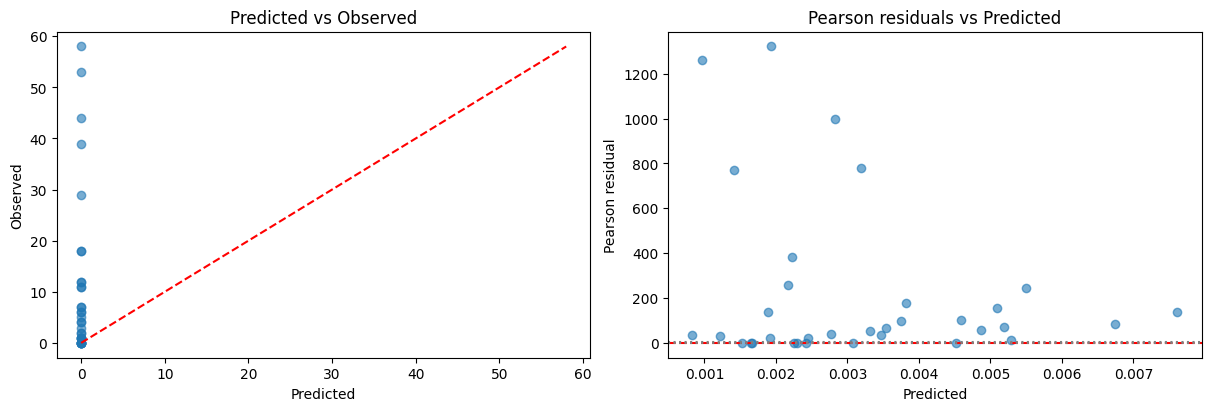

In [35]:
# 予測値 vs 実測値
ships["predicted"] = model_ships.predict(ships)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axes[0].scatter(ships["predicted"], ships["incidents"], alpha=0.6)
max_val = max(ships["predicted"].max(), ships["incidents"].max())
axes[0].plot([0, max_val], [0, max_val], "r--")
axes[0].set(xlabel="Predicted", ylabel="Observed",
            title="Predicted vs Observed")

# ピアソン残差
pearson_resid = (ships["incidents"] - ships["predicted"]) / np.sqrt(ships["predicted"])
axes[1].scatter(ships["predicted"], pearson_resid, alpha=0.6)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].axhline(2, color="gray", linestyle=":")
axes[1].axhline(-2, color="gray", linestyle=":")
axes[1].set(xlabel="Predicted", ylabel="Pearson residual",
            title="Pearson residuals vs Predicted")

plt.show()

## 参考文献

:::{card}

McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall.

GLMの原典。ポアソン回帰を含むGLM全般の理論

:::

:::{card}

Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.

カウントデータの回帰分析に特化した教科書。ポアソン回帰・負の二項回帰・過分散の詳細な議論

:::

:::{card}

Hilbe, J. M. (2011). *Negative Binomial Regression* (2nd ed.). Cambridge University Press.

負の二項回帰に特化した教科書。過分散への対処が詳しい

:::